Advanced Line Finding Project

by: Omar Armando Barrera Juarez

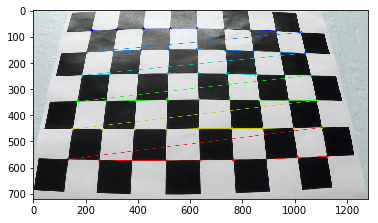

True

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import os

#Reading test image and defining grid size
img = cv2.imread("camera_cal/calibration3.jpg")
nx = 9
ny = 6

#Simple function used to find corners in a test image similar to the one used in the lectures
#Finds the corners using cv2, displays it the notebook and saves the image in "output_images/" folder.

def find_corners(img, nx, ny):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Finding the corners on the image
    ret, corners = cv2.findChessboardCorners(gray_img, (nx, ny), None)
    
    return gray_img, corners, ret

#Call the function
gray_img, corners, ret = find_corners(img, nx, ny)
#undist_img, corners, ret = undistorter(img, nx, ny)

#Draw found corners and display test image
cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
plt.imshow(img)
plt.show()

#Stores the Image
dirname = 'output_images'
cv2.imwrite(os.path.join(dirname, "img_corners.jpg"), img)

In [2]:
import glob

#This sections finds obj and img points used to calibrate the camera and obtain the parameters needed for img undistortion

#Defining a list to store the names of jpg files in the camera_cal folder, and the arrays for obj and img points
images = glob.glob("camera_cal/calibration*.jpg")
objpoints = []
imgpoints = []

#lists for obj points
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#Cycles through the images finding its respective corner points and storing data in the obj/img point list
for fname in images:
    img = mpimg.imread(fname)
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray_img, (9, 6), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

# Calibrates the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_img.shape[::-1], None, None)


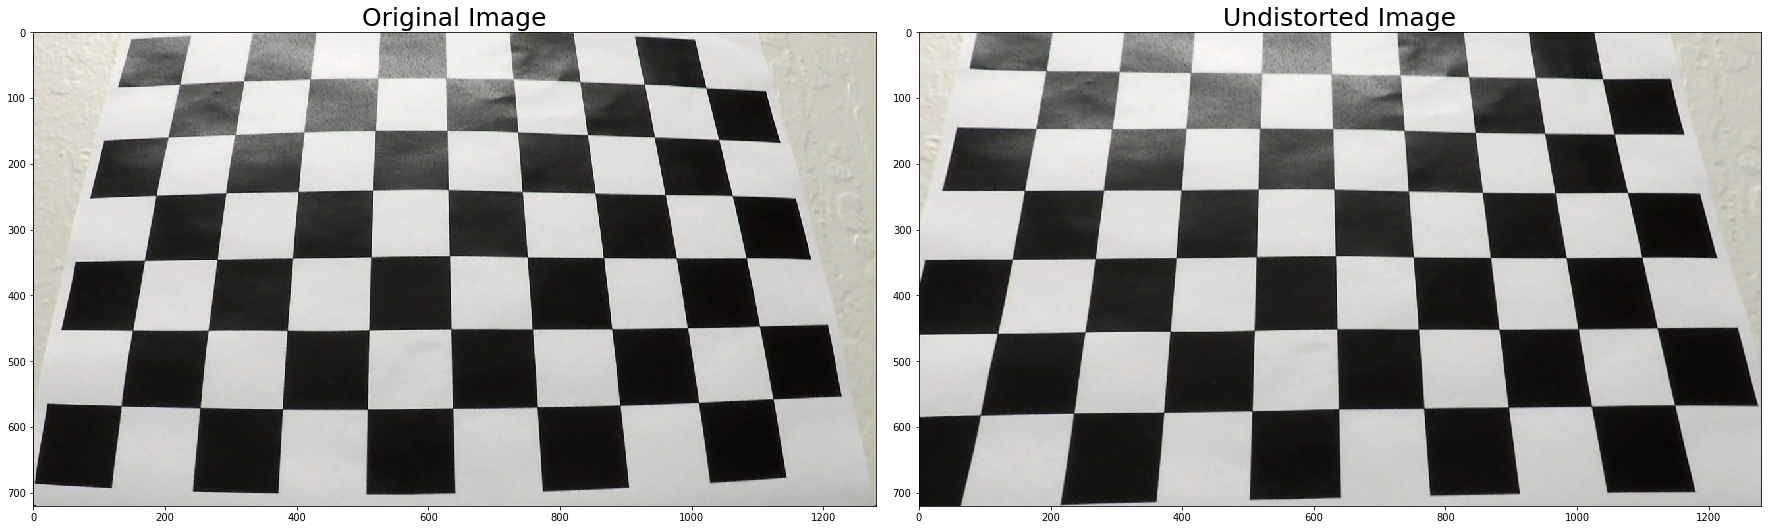

True

In [3]:
#Undistort sectiom, a simplen function used to undistort test images
#Makes use of the corners found before to calibrate the camera, distorts a test image, displays and store it in "output_images/" folder

#the image "calibration3.jpg" was chosen deliberately as it is easy to see how the curvature in the lower part is corrected
# any other image in the list can be undistorted by changing the file name below
img = mpimg.imread("camera_cal/calibration3.jpg")

#Simple function to undistort, gets the target image and the obj/img points list obtained in the previous step
def undistorter(img, objpoints, imgpoints):
    gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_img.shape[::-1], None, None)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist_img

#Calls the undistort function
undist_img = undistorter(img, objpoints, imgpoints)

#Code borrowed from the lecture to display original and corrected images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

#Stores the test image inside "output_images" folder
dirname = 'output_images'
cv2.imwrite(os.path.join(dirname, "undistorted_test.jpg"), undist_img)

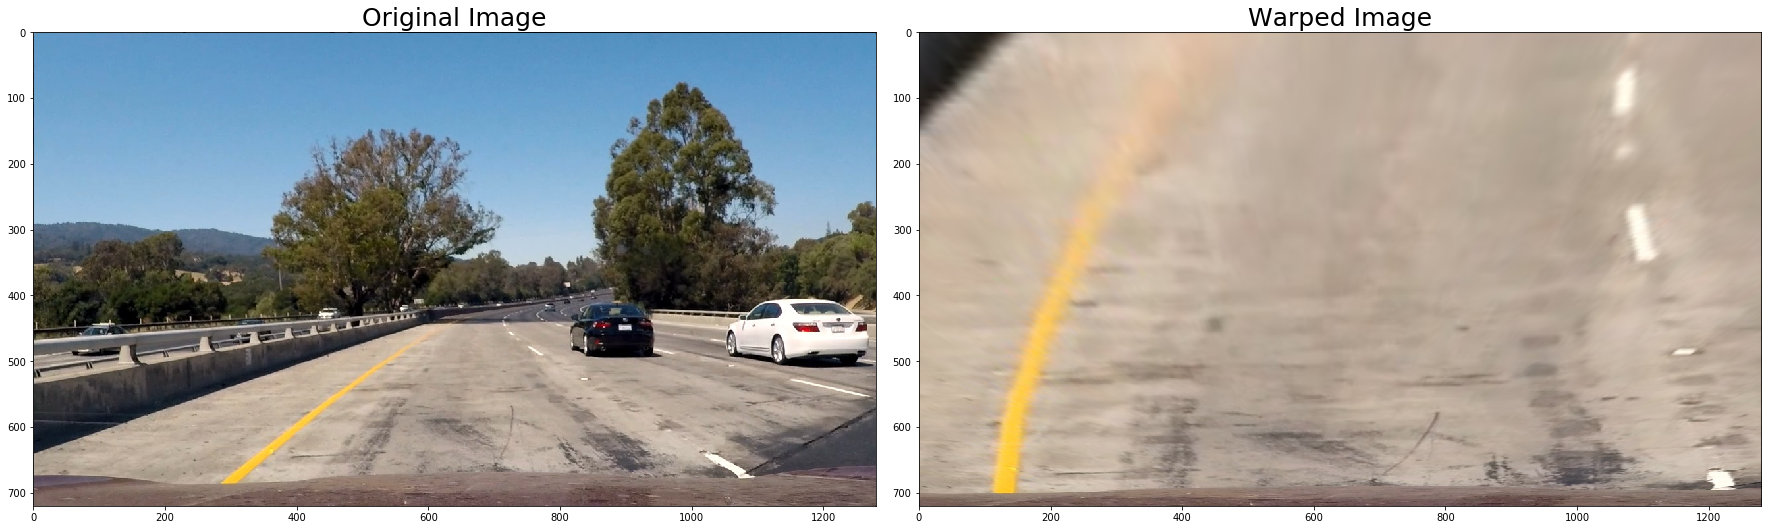

True

In [9]:
# This section takes one of the images of the road, applies a perspective transform to show the lines on bird-eye perspective

img = cv2.imread("test_images/test1.jpg")

def warper(img):
    src = np.float32([[750, 450],
                  [1200, 720],
                  [150, 720],
                  [550, 450]
                  ])

    dst = np.float32([[1280, 0],
                  [1280, 720],
                  [0, 720],
                  [0, 0]
                  ])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped_img = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)
    return warped_img, M, M_inv

warped_img, perspective_M, M_inv = warper(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
ax2.set_title('Warped Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

dirname = 'output_images'
cv2.imwrite(os.path.join(dirname, "warped_test.jpg"), warped_img)

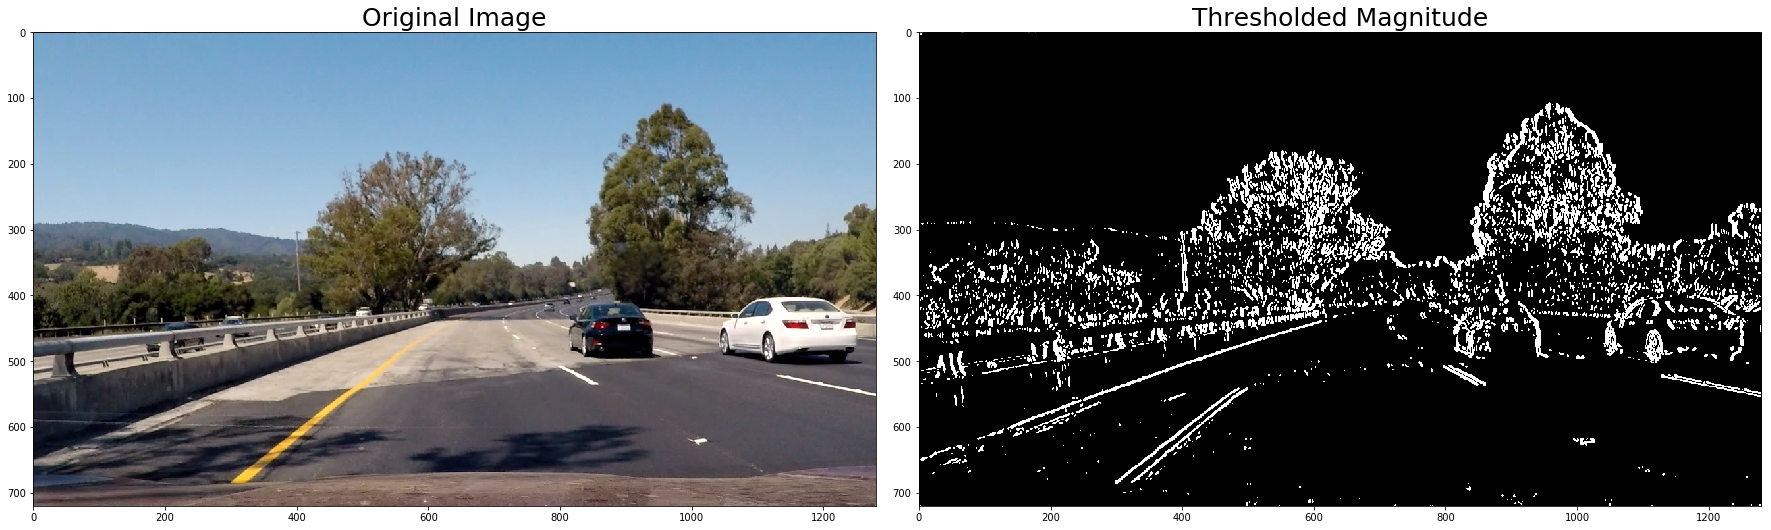

In [10]:
#Here we define functions for applying gradients (sobel in x, magnitude and direction)

def abs_sobel_x(img, sobel_kernel,  thresh_min, thresh_max):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

def mag_thresh(img, sobel_kernel, thresh_min, thresh_max):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    scale_factor = np.max(abs_sobelxy)/255 
    abs_sobelxy = (abs_sobelxy/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(abs_sobelxy)
    binary_output[(abs_sobelxy >= thresh_min) & (abs_sobelxy <= thresh_max)] = 1
    
    return binary_output

def dir_threshold(img, sobel_kernel, thresh_min, thresh_max):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_gradient = np.arctan2(abs_sobelx, abs_sobely)
    binary_output = np.zeros_like(dir_gradient)
    binary_output[(dir_gradient >= 0.7) & (dir_gradient <= 1.3)] = 1
    
    return binary_output

# test4 image was chosen deliberately as the contrast in the yellow line beteween the shaded region and the bright can be clearly seen
# the algortihm perfectly catches the line under shadows but completely fails at the bright part

img = cv2.imread("test_images/test4.jpg")

# Run the function
gradx = abs_sobel_x(img, sobel_kernel=9, thresh_min=20, thresh_max=200)
mag_binary = mag_thresh(img, sobel_kernel=9, thresh_min=100, thresh_max=150)
dir_binary = dir_threshold(img, sobel_kernel=9,thresh_min=0.7, thresh_max=1.3)

#finds the sobel in x, magnitude and magnitude direction gradients, then returns an image which uses a combination of these
def combiner(img):
    gradx = abs_sobel_x(img, sobel_kernel=9, thresh_min=20, thresh_max=200)
    mag_binary = mag_thresh(img, sobel_kernel=9, thresh_min=100, thresh_max=150)
    dir_binary = dir_threshold(img, sobel_kernel=9,thresh_min=0.7, thresh_max=1.3)
    
    combined = np.zeros_like(dir_binary)
    # I found that using only sobel in the x and ignoring y gave me the best results
    combined[(gradx == 1)| ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

combined = combiner(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

dirname = 'output_images'
#cv2.imwrite(os.path.join(dirname, "binary_test.jpg"), combined)

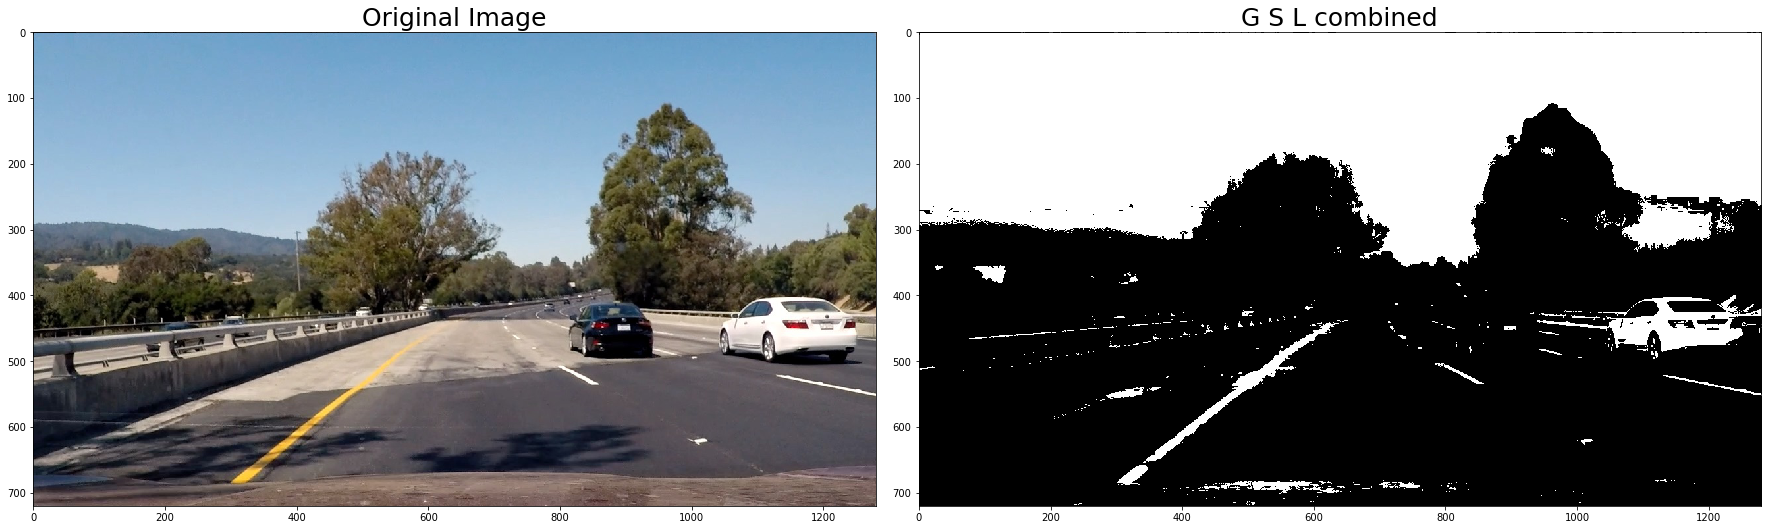

In [11]:
#Here we define  functions for obtaining data in the G, S and V channels 

# Selects data in G channel
def bgr_select(img, thresh_min, thresh_max):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    img = img[:,:,1] #green selector
    binary_output = np.zeros_like(img)
    binary_output[(img > thresh_min) & (img <= thresh_max)] = 1
    
    return binary_output

# Selects data in S or V channel
def hsv_select(img, select, thresh_min, thresh_max):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    if select == "s":
        channel = hsv[:,:,1]
    if select == "v":
        channel = hsv[:,:,2]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh_min) & (channel <= thresh_max)] = 1
    
    return binary_output

G_binary = bgr_select(img, thresh_min=200, thresh_max = 255)

S_binary = hsv_select(img, select = "s", thresh_min=55, thresh_max = 255)
L_binary = hsv_select(img, select = "v", thresh_min=150, thresh_max = 255)

#Combines S, V and G
def hsv_combiner(img):
    
    G_binary = bgr_select(img, thresh_min=200, thresh_max = 255)

    S_binary = hsv_select(img, select = "s", thresh_min=55, thresh_max = 255)
    L_binary = hsv_select(img, select = "v", thresh_min=150, thresh_max = 255)

    hsv_combined = np.zeros_like(S_binary)
    hsv_combined[((S_binary == 1) & (L_binary ==1)) | (G_binary ==1) ] = 1
    
    return hsv_combined

img = cv2.imread("test_images/test4.jpg")

hsv_combined = hsv_combiner(img)

# Using a combination of G S and L channels i was able to obtain good results in bright, shadow and in both yellow and white lines


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(hsv_combined, cmap='gray')
ax2.set_title('G S L combined', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

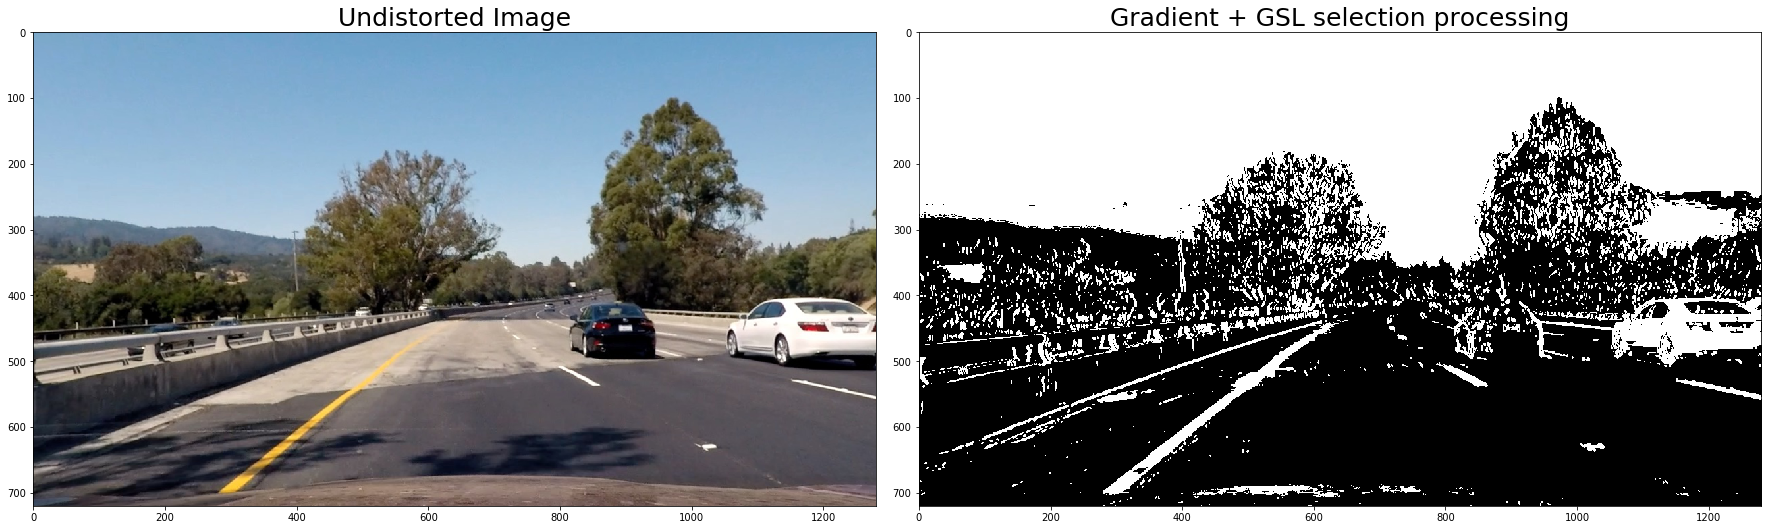

In [12]:
# In here i combine thre results of gradient combination results and hsv channel
img = cv2.imread("test_images/test4.jpg")

undist_img = undistorter(img, objpoints, imgpoints)

#Simple function used to combine gradients and GSL channels
def combiner_final(img):

    combined = combiner(img)
    hsv_combined = hsv_combiner(img)

    combined_final = np.zeros_like(combined)
    combined_final[(combined == 1) | (hsv_combined == 1)] = 1
    return combined_final

combined_final = combiner_final(undist_img)
#Combining all methods above i was able to obtain very decent line capturing amongh all regions regardless of line color
# shadowness and brightness in all test images

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image', fontsize=25)
ax2.imshow(combined_final, cmap='gray')
ax2.set_title('Gradient + GSL selection processing', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

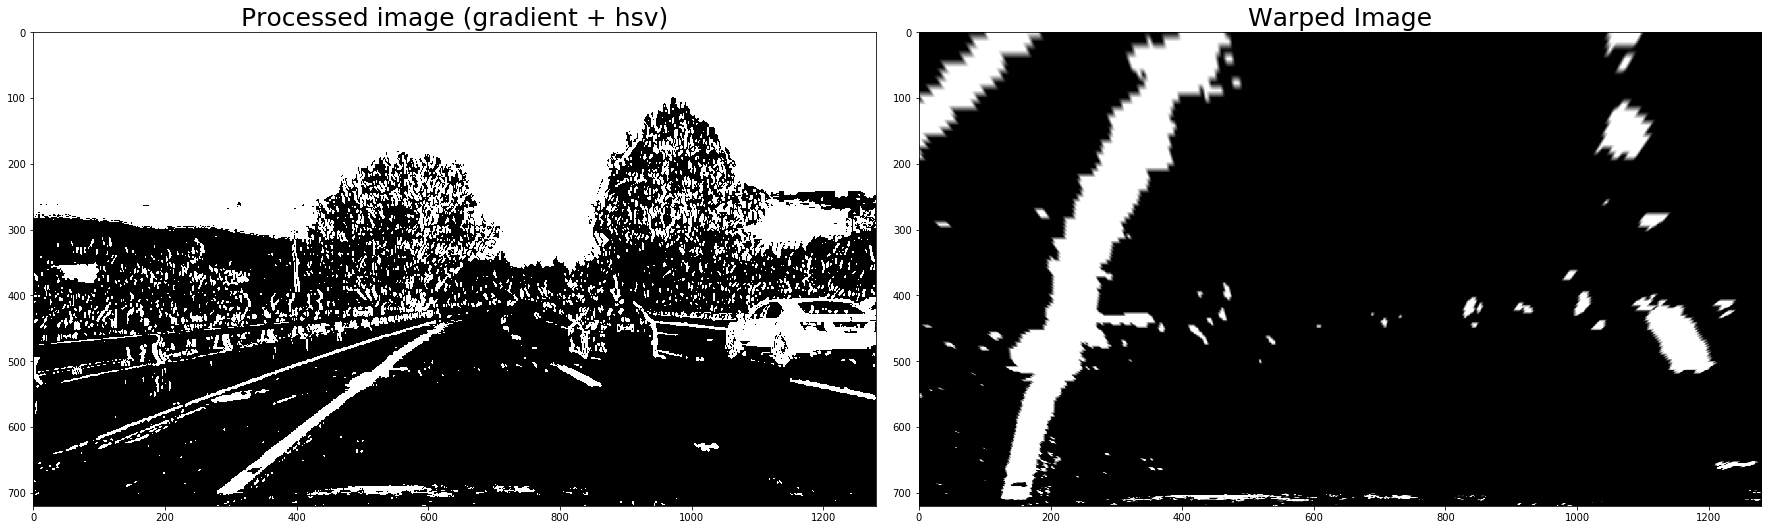

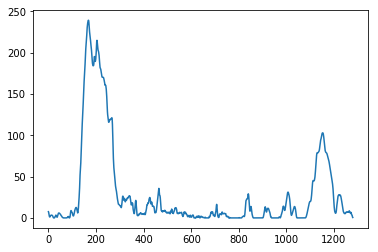

In [13]:
# Warping our last results

#warped, M = warper(img)
#combined_final = combiner_final(warped)
combined_final = combiner_final(undist_img)
warped, M, M_inv = warper(combined_final)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_final, cmap='gray')
ax1.set_title('Processed image (gradient + hsv)', fontsize=25)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()


In [14]:
# Line finding as per the lectures

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

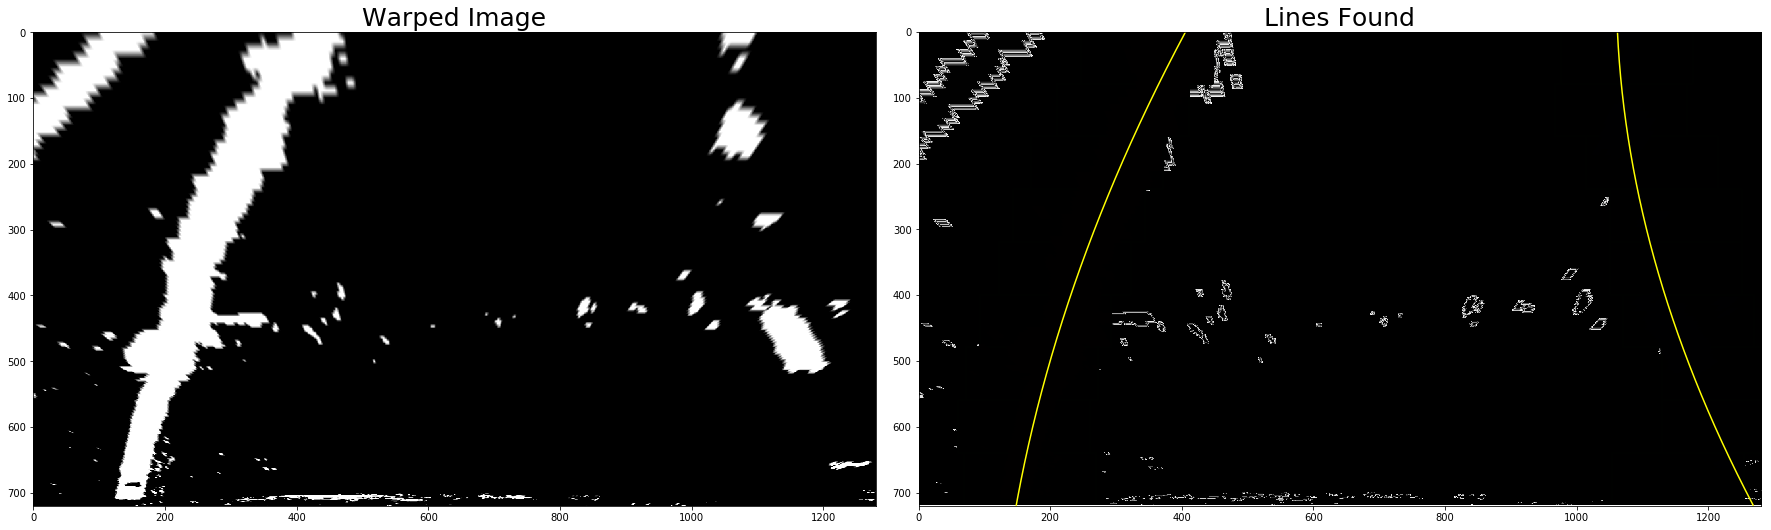

In [15]:
# Line finding as per the lectures


# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#plt.imshow(out_img)
#plt.plot(left_fitx, ploty, color='yellow')
#plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)
#plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped, cmap='gray')
ax1.set_title('Warped Image', fontsize=25)
ax2.imshow(out_img)
ax2.set_title('Lines Found', fontsize=25)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


In [16]:
# Data for radius plotting as per lectures
ploty = np.linspace(0, 719, num=720)
# Define conversions in x and y from pixels space to meters
#y_eval = np.max(ploty)
y_eval = warped.shape[0]

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
#left_fit_cr = np.polyfit(poly*ym_per_pix, leftx*xm_per_pix, 2)
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radius of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


669.324051433 m 497.208370938 m


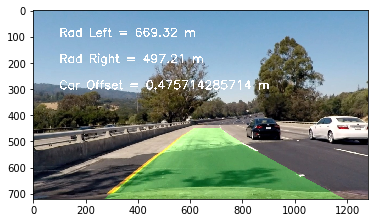

True

In [17]:
#Plots final lines detected, radius calculated on undistorted image
# code borrowed from lectures

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 

# Get lowest values from newwerp for the calculation of car offset from center of the lines
x_min = np.amin(newwarp.nonzero()[1])
x_max = np.amax(newwarp.nonzero()[1])
line_center = (x_max + x_min)/2
car_offset_pixel = abs((newwarp.shape[1]/2) - line_center)
#converting value to meters
car_offset_m = car_offset_pixel * 3.7/700

# Combine the result with the original image
result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
#result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
#plt.imshow(colorwarp, cmap='gray')
left_curverad_str = str(round(left_curverad, 2))
right_curverad_str = str(round(right_curverad, 2))
cv2.putText(result,"Rad Left = " + left_curverad_str +" m", (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),4)
cv2.putText(result,"Rad Right = " + right_curverad_str +" m", (100,200), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),4)
cv2.putText(result,"Car Offset = " + str(car_offset_m) + " m", (100,300), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),4)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

#Stores test image
dirname = 'output_images'
cv2.imwrite(os.path.join(dirname, "Lines detected.jpg"), result)

Testing the pipeline on the video.

In [18]:
# Import everything needed to edit/save/watch video clips
# *** Code imported from Project 1! ***
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [19]:
#Pipeline as above applied in continuation for video

def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    #Undistorts the image
    undist_img = undistorter(img, objpoints, imgpoints)
    #Makes a combination of gradient, HSV and G channel selection to find lines
    combined_final = combiner_final(undist_img)
    #Warps the image to top view
    warped, M, M_inv = warper(combined_final)
    
    #Applies the road line finding code as presented in the lectures
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    """
    # Generate some fake data to represent lane-line pixels
    ploty_1 = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty_1])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty_1])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty_1, leftx, 2)
    left_fitx_1 = left_fit[0]*ploty_1**2 + left_fit[1]*ploty_1 + left_fit[2]
    right_fit = np.polyfit(ploty_1, rightx, 2)
    right_fitx_1 = right_fit[0]*ploty_1**2 + right_fit[1]*ploty_1 + right_fit[2]
    
    """
    
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # rounding to radius values to 2 decimals

    left_curverad_str = str(round(left_curverad, 2))
    right_curverad_str = str(round(right_curverad, 2))
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0]))
    
    # Get lowest values from newwerp for the calculation of car offset from center of the lines
    x_min = np.amin(newwarp.nonzero()[1])
    x_max = np.amax(newwarp.nonzero()[1])
    line_center = (x_max + x_min)/2
    car_offset_pixel = abs((newwarp.shape[1]/2) - line_center)
    #converting value to meters and rouding to 2 decimals
    car_offset_m = str(round(car_offset_pixel * 3.7/700, 2))

    # Stamp radius values on top of frame
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    cv2.putText(result,"Rad Left = " + left_curverad_str +" m", (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),4)
    cv2.putText(result,"Rad Right = " + right_curverad_str +" m", (100,200), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),4)
    cv2.putText(result,"Car Offset = " + car_offset_m + " m", (100,300), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),4)
    
    return result

In [21]:
white_output = 'project_video_detected.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video project_video_detected.mp4
[MoviePy] Writing video project_video_detected.mp4


100%|█████████████████████████████████████▉| 1260/1261 [19:55<00:00,  1.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_detected.mp4 

Wall time: 19min 56s


In [84]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))
